In [1]:
# Variables for configuration
generate_pandas_profiling_reports = False
process_preprocessed_data_of_uci = False
print_pair_plots = False

In [2]:
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
mpl.rc('image', cmap='coolwarm')

# set pandas to show all columns of the df when using the display function
pd.set_option('display.max_columns', None)

In [3]:
# list the datasets that should be used in the current run
datasets = ["hungarian", "cleveland", "switzerland", "long-beach-va"]

In [4]:
# custom function to read the dataset into a csv formated string
# the name is used as a delimiter here because it is the last feature and common among all entrys 
def readRawData(filePath:str):
    with open(filePath) as file:
        dataString = file.read()
        dataString = dataString.replace("\n"," ")
        dataString = dataString.replace("name ","name\n")
        dataString = dataString.replace(" ",",")
        return dataString

In [5]:
# read the data from the specified datasets into the df 
from io import StringIO
df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(StringIO(readRawData("./Data/"+ dataset +".data")), header=None, sep=",")
    dataset_df['dataset'] = dataset
    df = pd.concat([df,dataset_df ], ignore_index=True)

In [6]:
df.columns=["id", "ccf", "age", "sex", "painloc", "painexer" , "relrest" , "pncaden" , "cp", "trestbps", "htn", "chol", "smoke", "cigs", "years", "fbs", "dm", "famhist", "restecg", "ekgmo", "ekgday", "ekgyr", "dig", "prop", "nitr", "pro", "diuretic", "proto", "thaldur", "thaltime", "met", "thalach", "thalrest", "tpeakbps", "tpeakbpd", "dummy", "trestbpd", "exang", "xhypo", "oldpeak", "slope", "rldv5", "rldv5e", "ca", "restckm", "exerckm", "restef", "restwm", "exeref", "exerwm", "thal", "thalsev", "thalpul", "earlobe", "cmo", "cday", "cyr", "num", "lmt", "ladprox", "laddist", "diag", "cxmain", "ramus", "om1", "om2", "rcaprox", "rcadist", "lvx1", "lvx2", "lvx3", "lvx4", "lvf", "cathef", "junk", "name", "dataset"]

# Data cleanup

In [7]:
# the dataset encodes unfilled cells with -9 they are replaced with NaN for better compatibility with pd
df = df.replace(-9, float('nan'))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/finn/miniconda3/envs/dataMiningProject/lib/python3.9/site-packages/pandas_profiling/model/correlations.py:55: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/pandas-profiling/issues
(include the error message: 'No data; `observed` has size 0.')
  warnings.warn(
/home/finn/miniconda3/envs/dataMiningProject/lib/python3.9/site-packages/missingno/missingno.py:254: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(
/home/finn/miniconda3/envs/dataMiningProject/lib/python3.9/site-packages/pandas_profiling/model/missing.py:89: UserWarning: There was an attempt to generate the Count missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.prof

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

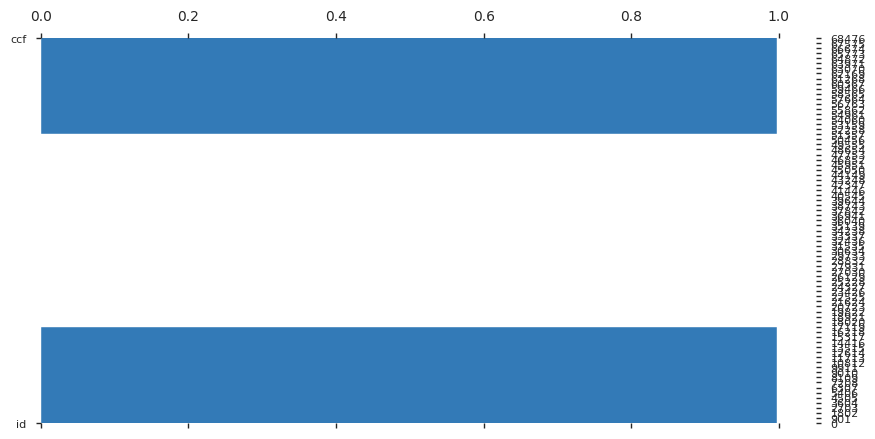

In [8]:
if generate_pandas_profiling_reports:
    profile = ProfileReport(df, title='Pandas Profiling Report for all features')
    profile.to_file("Pandas Profiling Report for all features.html")

The columns smoke and years both describe whether a respondent smokes or not. Smoke does this by being binary coded, while years describes the number of years a person has smoked. Due to the high number of missing values, the columns are useless on their own. However, it is possible to enrich the smoke column with the years column. 

In [9]:
print(f"Number of NaNs in smoke: {df['smoke'].isna().sum()}")
df.loc[(df['smoke'].isna()) & (df['years'] == 0),'smoke'] = 0
df.loc[(df['smoke'].isna()) & (df['years'] > 0),'smoke'] = 1
print(f"Number of NaNs in smoke after combination with years: {df['smoke'].isna().sum()}")
df.loc[(df['smoke'].isna()) & (df['cigs'] == 0),'smoke'] = 0
df.loc[(df['smoke'].isna()) & (df['cigs'] > 0),'smoke'] = 1
print(f"Number of NaNs in smoke after combination with years and cigs: {df['smoke'].isna().sum()}")

Number of NaNs in smoke: 671
Number of NaNs in smoke after combination with years: 391
Number of NaNs in smoke after combination with years and cigs: 389


Finding: reduces the number of missing values in smoke by 280 entries. 

## Explore how many NaNs and zeros are within one column for each attribute.

In [10]:
(df.loc[ : , df.columns != 'dataset'].isna()).join(df['dataset']).groupby("dataset").sum()

,id,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,ekgmo,ekgday,ekgyr,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,dummy,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restckm,exerckm,restef,restwm,exeref,exerwm,thal,thalsev,thalpul,earlobe,cmo,cday,cyr,num,lmt,ladprox,laddist,diag,cxmain,ramus,om1,om2,rcaprox,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,cathef,junk,name
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cleveland,0,0,0,0,282,282,282,282,0,0,0,0,4,5,5,0,259,0,0,0,0,0,2,2,2,2,2,0,0,69,0,0,0,0,0,0,0,0,0,0,0,282,0,2,282,282,282,282,282,282,2,282,282,282,0,0,0,0,0,0,0,282,0,282,0,282,0,0,0,0,0,0,0,282,282,0
hungarian,1,1,1,1,1,1,1,295,1,2,2,24,283,294,295,9,274,294,2,1,1,1,2,3,2,2,2,10,3,191,3,2,2,2,2,2,2,2,3,1,191,2,1,291,295,295,295,292,295,293,267,268,278,295,1,1,1,1,276,237,247,277,236,286,272,290,245,270,1,1,1,1,1,267,295,1
long-beach-va,1,1,1,1,1,1,5,201,1,57,4,8,2,11,13,8,158,9,1,53,54,53,61,61,60,60,74,54,54,161,54,54,55,60,60,57,57,54,54,57,102,66,66,199,201,200,173,174,199,198,160,170,200,200,3,1,1,1,1,1,1,1,1,1,1,2,2,2,3,3,3,3,4,24,82,1
switzerland,0,0,0,0,0,0,0,123,0,2,30,0,100,112,121,75,115,121,1,1,1,1,5,2,3,1,6,50,1,34,50,1,1,3,3,2,2,1,3,6,17,77,77,118,123,123,123,123,123,123,50,51,97,123,9,9,9,0,0,0,0,0,0,0,0,0,0,0,17,17,17,17,13,17,123,0


In [11]:
(df.loc[ : , df.columns != 'dataset'].eq(0)).join(df['dataset']).groupby("dataset").sum()

,id,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,ekgmo,ekgday,ekgyr,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,dummy,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restckm,exerckm,restef,restwm,exeref,exerwm,thal,thalsev,thalpul,earlobe,cmo,cday,cyr,num,lmt,ladprox,laddist,diag,cxmain,ramus,om1,om2,rcaprox,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,cathef,junk,name
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cleveland,0,282,0,91,0,0,0,0,0,0,108,0,115,115,115,240,0,107,138,0,0,0,271,186,211,252,248,0,0,43,0,0,0,0,0,0,0,190,276,91,0,0,0,166,0,0,0,0,0,0,0,0,0,0,0,0,0,157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
hungarian,0,294,0,81,23,164,141,0,0,0,195,0,10,0,0,266,0,1,235,0,0,0,293,274,265,269,290,0,0,0,0,0,0,0,0,0,0,204,291,189,0,0,0,3,0,0,0,3,0,2,0,6,7,0,0,0,0,188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
long-beach-va,0,200,0,6,15,65,33,0,0,1,90,49,96,38,38,125,4,100,80,0,0,0,122,88,61,105,94,0,0,2,0,0,0,0,0,1,1,52,139,40,1,0,0,2,0,1,0,10,0,2,0,9,1,1,0,0,0,51,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
switzerland,0,123,0,10,11,22,27,0,0,0,60,123,5,0,0,43,0,0,85,0,0,0,116,70,75,66,93,0,0,25,0,0,0,0,0,0,0,68,113,42,0,0,0,0,0,0,0,0,0,0,0,21,23,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### drop columns that are not used for prediction

In [12]:
columns_to_drop = [
    "id", # A id is not relevant for a model
    "painloc", # to many missing values (31,5%)
    "painexer", # to many missing values (31,5%)
    "relrest", # to many missing values (31,5%)
    "ccf", # the social security number does not influence if you have a heart disease or not
    "pncaden", # sum of painlox painexer relrest -> the features are already in the dataset -> drop because it is a duplicate
    "chol", # 20% of the data contain 0 as value -> unrealistic value for cholesterin
    "smoke", # dropped because to many values are NaN, although it is combined with years and cigs
    "years", # combined with smoke
    "cigs", # combined with smoke
    "dm", # to many missing values (89,5%)
    "famhist", # to many missing values (47,1%)
    "ekgmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "proto", # The exercises carried out during the survey
    # "thaldur", # duration of exercise test in minutes -> does not influence if you have a heartdeseade or not
    "thaltime", # to many missing values (50.5%)
    "dummy", # no description available -> from the name does not seem relevant
    # "xhypo", # no description available -> could not be interpreted later on
    "slope", # to many missing values (30,4%)
    "rldv5", # to many missing values (47,4%)
    "ca", # to many missing values (67,7%)
    "restckm", # irrelevant according to the uci
    "exerckm", # irrelevant according to the uci
    "restef", # to many missing values (96,9%)
    "restwm", # to many missing values (96,7%)
    "exeref", # to many missing values (99,8%)
    "exerwm", # to many missing values (99,4%)
    "thal", # to many missing values (53,2%)
    "thalsev", # to many missing values (85,6%)
    "thalpul", # to many missing values (95,1%)
    "earlobe", # Constant
    "cmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "lmt", # to many missing values (30,7%)
    "ladprox", # to many missing values (26,4%)
    "laddist", # to many missing values (27,5%)
    "diag", # to many missing values (62,2%)
    "cxmain", # to many missing values (26,3%)
    "ramus", # to many missing values (63,2%)
    "om1", # to many missing values (30,3%)
    "om2", # to many missing values (63,7%)
    "rcaprox", # to many missing values (27,4%)
    "rcadist", # to many missing values (30,2%)
    # "lvx1",
    # "lvx2",
    # "lvx3",
    # "lvx4",
    # "lvf",
    "cathef", # to many missing values (65,5%)
    "junk", # to many missing values (86,8%)
    "name" # Constant
]
df.drop(columns_to_drop, inplace=True, axis=1)

In [13]:
df['dataset'].value_counts()

hungarian        295
cleveland        282
long-beach-va    201
switzerland      123
Name: dataset, dtype: int64

## Treatment of different scales in the datasets
### met

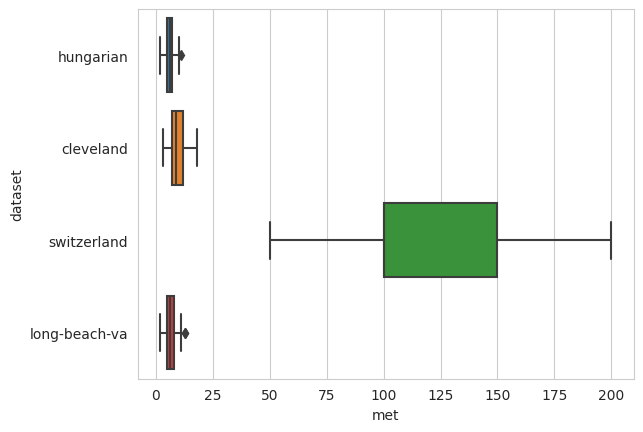

In [14]:
# plot to show the reason why we need to process this data:
sns.boxplot(x="met",y="dataset",data= df)
plt.show()

In [15]:
df.loc[df["dataset"] == "switzerland", "met"] = df.loc[df["dataset"] == "switzerland", "met"]/10

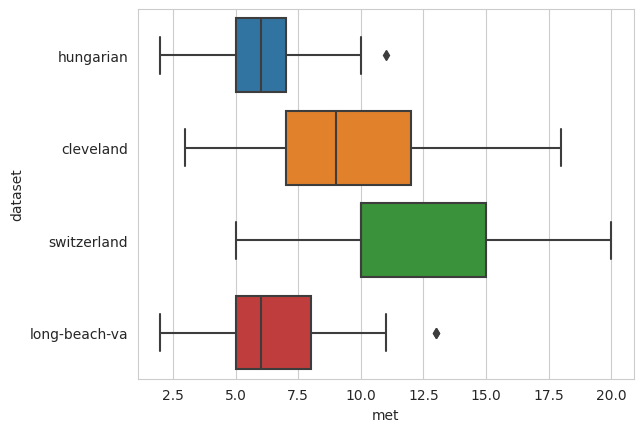

In [16]:
# plot to show the reason why we need to process this data:
sns.boxplot(x="met",y="dataset",data= df)
plt.show()

### rldv5e

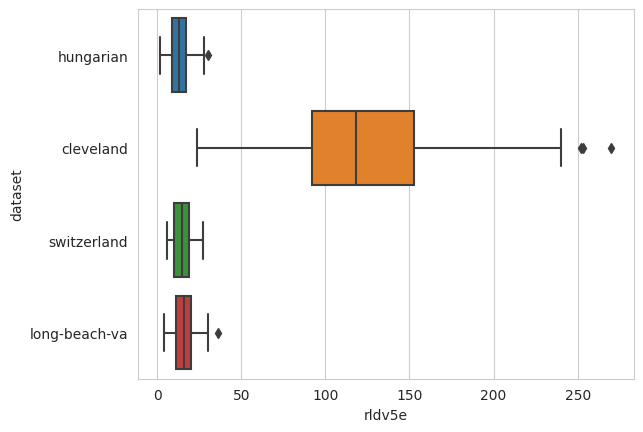

In [17]:
# plot to show the reason why we need to process this data: 
sns.boxplot(x="rldv5e",y="dataset",data= df)
plt.show()

In [18]:
df.loc[df["dataset"] == "cleveland", "rldv5e"] = df.loc[df["dataset"] == "cleveland", "rldv5e"]/10

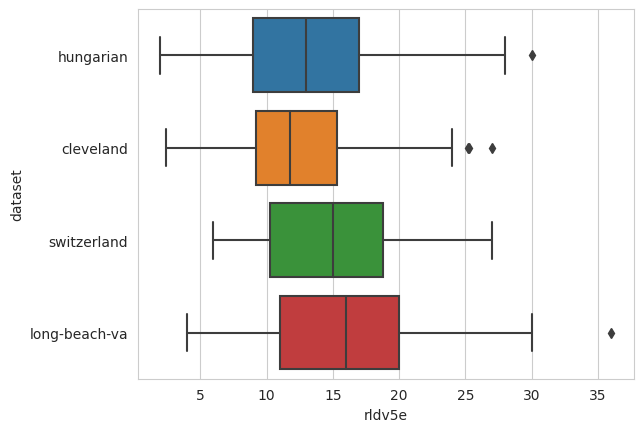

In [19]:
# plot to show the reason why we drop:
sns.boxplot(x="rldv5e",y="dataset",data= df)
plt.show()

## drop by rows because of unrealistic values

In [20]:
# All values beyond 18 are not realistic -> also 18 is a value that is only archived by very sporty people
# https://blog.nasm.org/metabolic-equivalents-for-weight-loss
print(f"Shape before drop of met vlaues that are unrealistic: {df.shape}")
df.drop(df[df['met']> 18].index, inplace=True, axis=0)
print(f"Shape after drop of met vlaues that are unrealistic: {df.shape}")

Shape before drop of met vlaues that are unrealistic: (901, 30)
Shape after drop of met vlaues that are unrealistic: (900, 30)


In [21]:
# leave the dead ones behind
# drop entries with a blood pressure of 0
print(f"Shape before drop of entrys with a blood preasure of 0: {df.shape}")
df.drop(df[df['trestbps'] == 0].index, inplace=True, axis=0)
print(f"Shape after drop of entrys with a blood preasure of 0: {df.shape}")

Shape before drop of entrys with a blood preasure of 0: (900, 30)
Shape after drop of entrys with a blood preasure of 0: (899, 30)


# drop more columns because switzerland would be lost

In [22]:
# what would happen
df.dropna(axis=0, how='any').loc[:,"dataset"].value_counts()

cleveland        280
hungarian        277
long-beach-va    105
Name: dataset, dtype: int64

In [23]:
# because of which features
(df.loc[ : , df.columns != 'dataset'].isna()).join(df['dataset']).groupby("dataset").sum()

,age,sex,cp,trestbps,htn,fbs,restecg,dig,prop,nitr,pro,diuretic,thaldur,met,thalach,thalrest,tpeakbps,tpeakbpd,trestbpd,exang,xhypo,oldpeak,rldv5e,num,lvx1,lvx2,lvx3,lvx4,lvf
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cleveland,0,0,0,0,0,0,0,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
hungarian,1,1,1,2,2,9,2,2,3,2,2,2,3,3,2,2,2,2,2,2,3,1,1,1,1,1,1,1,1
long-beach-va,1,1,1,57,4,8,1,61,61,60,60,73,54,54,54,55,60,60,57,54,54,57,66,1,3,3,3,3,4
switzerland,0,0,0,2,30,75,1,5,2,3,1,6,1,50,1,1,3,3,2,1,3,6,76,0,17,17,17,17,13


In [24]:
df.drop(["met", "fbs", "rldv5e", "htn"], inplace=True, axis=1)

In [25]:
# what would happen now
df.dropna(axis=0, how='any').loc[:,"dataset"].value_counts()

hungarian        288
cleveland        280
long-beach-va    117
switzerland       92
Name: dataset, dtype: int64

In [26]:
if generate_pandas_profiling_reports:
    profile = ProfileReport(df, title='Pandas Profiling Report for selected features')
    profile.to_file("Pandas Profiling Report for selected features.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [212]:
# drop all entries which contain one or more NanN vlaues
print(f"Shape before drop of NaN containing rows: {df.shape}")
df.dropna(inplace=True, axis=0, how='any')
print(f"Shape after drop of NaN containing rows: {df.shape}")

Shape before drop of NaN containing rows: (899, 26)
Shape after drop of NaN containing rows: (777, 26)


In [213]:
df['dataset'].value_counts()

hungarian        288
cleveland        280
long-beach-va    117
switzerland       92
Name: dataset, dtype: int64

# Visualize Data

In [214]:
if print_pair_plots:
    sns.pairplot(df, hue="num", palette="tab10")

In [215]:
if print_pair_plots:
    sns.pairplot(df, hue="dataset", palette="tab10")

In [216]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
df.loc[df['num'] >= 1,"num"] = 1
df['num'] = labelEncoder.fit_transform(df['num'])

In [217]:
if print_pair_plots:
    sns.pairplot(df, hue="num", palette="tab10")

<AxesSubplot:>

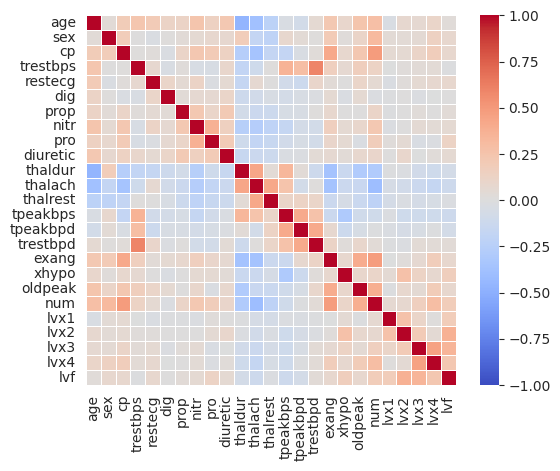

In [218]:
# Compute the correlation matrix
corr = df.corr()
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=.5, vmin=-1, vmax=1)

# Train the different models

In [219]:
X = df.loc[:,(df.columns!= 'num') & (df.columns != 'dataset')]
y = df['num']

Accuracy for CatBoostClassifier = 79.13419913419914


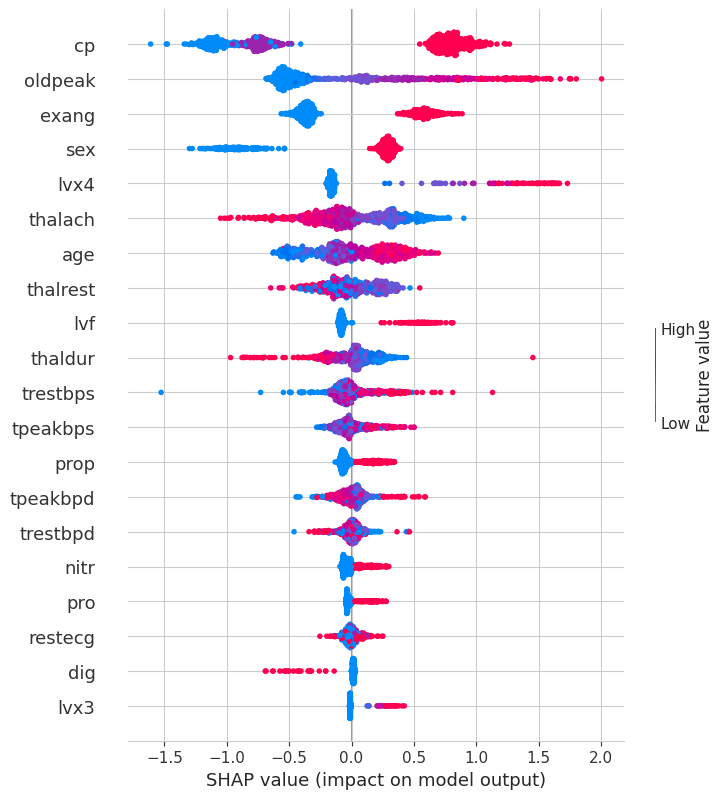

In [221]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import shap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from  sklearn.naive_bayes import *

estimator = XGBClassifier(random_state=47, n_jobs=-1)
estimator = CatBoostClassifier(random_state=42, thread_count=-1, silent= True)
accuracy_best = cross_val_score(estimator, X, y, cv=10, scoring='accuracy', n_jobs=-1, error_score='raise')
print(f"Accuracy for {estimator.__class__.__name__} = {accuracy_best.mean() * 100.0}")

estimator.fit(X,y)
explainer = shap.Explainer(estimator)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

In [131]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from  sklearn.naive_bayes import *

estimators_and_hyperparameters=[
    {"estimator": CatBoostClassifier(random_state=42, thread_count=-1, silent= True), "parameters": {}},
    {"estimator": XGBClassifier(random_state=42, n_jobs=-1), "parameters": {'classification__n_estimators': [100,125,150,175,200,225,250],
                                                                            'classification__max_depth': [2,4,6,8,10]}},
    {"estimator": SVC(kernel='linear',random_state=42), "parameters": {}},
    {"estimator": SVC(kernel='poly',random_state=42), "parameters": {}},
    {"estimator": SVC(kernel='rbf',random_state=42), "parameters": {}},
    {"estimator": SVC(kernel='sigmoid',random_state=42), "parameters": {}},
    # only for square matrix -> not used {"estimator": SVC(kernel='precomputed',random_state=42), "parameters": {}},
    {"estimator": BernoulliNB(), "parameters": {}},
    {"estimator": CategoricalNB(), "parameters": {}},
    {"estimator": ComplementNB(), "parameters": {}},
    {"estimator": GaussianNB(), "parameters": {}},
    {"estimator": MultinomialNB(), "parameters": {}},
    {"estimator": DecisionTreeClassifier(random_state=42), "parameters": {}},
    {"estimator": KNeighborsClassifier(n_jobs=-1), "parameters": {'classification__n_neighbors': range(2, 9)}},
    {"estimator": RandomForestClassifier(random_state=42, n_jobs=-1), "parameters": {}},
    {"estimator": SGDClassifier(), "parameters": {}}
]

In [132]:
from sklearn.preprocessing import *
scalers = [
    {"scaler": MaxAbsScaler(), "parameters": {}},
    {"scaler": MinMaxScaler(), "parameters": {}},
    {"scaler": Normalizer(), "parameters": {}},
    {"scaler": PowerTransformer(), "parameters": {}},
    {"scaler": RobustScaler(), "parameters": {}},
    {"scaler": StandardScaler(), "parameters": {'normalisation__with_mean': [ True, False],'normalisation__with_std': [ True, False]}}
]

In [133]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# build pipelines
# create the pipeline
pipelines = []
for scaler in scalers:
    print(f"Scaler: {scaler.get('scaler').__class__.__name__}")
    for estimator in estimators_and_hyperparameters:
        parameters = scaler.get("parameters") | estimator.get("parameters")
        pipeline = Pipeline(steps=[ ('normalisation', scaler.get("scaler")), ('classification', estimator.get("estimator")) ])
        # create the grid search instance
        grid_search_estimator = GridSearchCV(pipeline, parameters, scoring='accuracy', cv=10, error_score='raise')
        try:
            accuracy_best = cross_val_score(grid_search_estimator, X, y, cv=10, scoring='accuracy', n_jobs=-1, error_score='raise')
            grid_search_estimator.fit(X, y)
            print(f"Accuracy for {estimator.get('estimator').__class__.__name__} = {accuracy_best.mean() * 100.0}")
            display(grid_search_estimator.best_params_)
        except Exception as e:
            print(f'Skipping the combination of {scaler.get("scaler").__class__.__name__} and {estimator.get("estimator").__class__.__name__} because:')
            print(str(e))
            print()



    print("-----------------------------------------------------------------")


Scaler: MaxAbsScaler
Accuracy for CatBoostClassifier = 78.32748024582968


{}

Accuracy for XGBClassifier = 77.30026338893767


{'classification__max_depth': 2, 'classification__n_estimators': 150}

Accuracy for SVC = 78.92010535557506


{}

Accuracy for SVC = 76.56935908691835


{}

Accuracy for SVC = 77.89508340649692


{}

Accuracy for SVC = 51.97980684811239


{}

Accuracy for BernoulliNB = 75.68261633011414


{}

Accuracy for CategoricalNB = 77.60096575943811


{}

Skipping the combination of MaxAbsScaler and ComplementNB because:
Negative values in data passed to ComplementNB (input X)

Accuracy for GaussianNB = 78.76646180860403


{}

Skipping the combination of MaxAbsScaler and MultinomialNB because:
Negative values in data passed to MultinomialNB (input X)

Accuracy for DecisionTreeClassifier = 72.14881474978051


{}

Accuracy for KNeighborsClassifier = 75.69798068481124


{'classification__n_neighbors': 7}

Accuracy for RandomForestClassifier = 78.47234416154521


{}

Accuracy for SGDClassifier = 73.92230026338893


{}

-----------------------------------------------------------------
Scaler: MinMaxScaler


KeyboardInterrupt: 

In [ ]:
if not process_preprocessed_data_of_uci:
    raise SystemExit("So Feierabend Emma")

# Tests with the preprocessed data by the UCI

In [ ]:
import pandas as pd 
datasets = ["hungarian", "cleveland", "switzerland", "va"]
df_processed = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv("./Data/processed."+ dataset +".data", header=None, sep=",")
    dataset_df['dataset'] = dataset
    df_processed = pd.concat([df_processed,dataset_df ], ignore_index=True)
df_processed.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num', 'dataset']
df_processed = df_processed.replace('?', float('nan'))


In [ ]:
df_processed[['trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']] = df_processed[['trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']].apply(pd.to_numeric)

In [ ]:
(df_processed.loc[ : , df_processed.columns != 'dataset'].isna()).join(df_processed['dataset']).groupby("dataset").sum()

In [ ]:
df_processed.drop(["slope", "ca","thal"], inplace=True, axis=1)

In [ ]:
print(f"Shape before drop of NaN containing rows: {df_processed.shape}")
df_processed.dropna(inplace=True, axis=0, how='any')
print(f"Shape after drop of NaN containing rows: {df_processed.shape}")

In [ ]:
df_processed.shape

In [ ]:
df_processed.head()

In [ ]:
df_processed.describe()

In [ ]:
if generate_pandas_profiling_reports:
    profile = ProfileReport(df_processed, title='Pandas Profiling Report for the features processed by the UCI')
    profile.to_file("Pandas Profiling Report for the features processed by the UCI.html")

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
df_processed.loc[df_processed['num'] >= 1,"num"] = 1
df_processed['num'] = labelEncoder.fit_transform(df_processed['num'])

In [ ]:
X = df_processed.loc[:,(df_processed.columns!= 'num') & (df_processed.columns != 'dataset')]
y = df_processed['num']

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from statistics import mean
for scaler in scalers:
    print(f'Current Sclaer: {scaler.__class__.__name__}')
    for estimator in estimators_and_hyperparameters:
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        try:
            X_trans = scaler.fit_transform(X)
            scores = cross_val_score(estimator[0], X_trans, y, scoring='f1',cv=skf, n_jobs=-1)
            print(f'F1 score for {estimator[0].__class__.__name__}: {mean(scores)}')
        except Exception as e:
            print(e)
            print(f'Skipping the combination of {scaler.__class__.__name__} and {estimator[0].__class__.__name__}')
    print('-----------------------------------------------------------------')
print(f'Current Sclaer: NoScaler')
for estimator in estimators_and_hyperparameters:
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    try:
        X_trans = X
        scores = cross_val_score(estimator[0], X_trans, y, scoring='f1',cv=skf, n_jobs=-1)
        print(f'F1 score for {estimator[0].__class__.__name__}: {mean(scores)}')
    except Exception as e:
        print(e)
        print(f'Skipping the combination of NoScaler and {estimator[0].__class__.__name__}')
print('-----------------------------------------------------------------')

In [ ]:
# Tests with the preprocessed data by the UCI includeing the reprocessed data

In [ ]:
import pandas as pd 
datasets = ["hungarian", "cleveland", "switzerland", "va"]
df_processed = pd.DataFrame()
for dataset in datasets:
    if dataset != "hungarian":
        dataset_df = pd.read_csv("./Data/processed."+ dataset +".data", header=None, sep=",")
        dataset_df['dataset'] = dataset
        df_processed = pd.concat([df_processed,dataset_df ], ignore_index=True)
with open("Data/reprocessed.hungarian.data") as file:
    dataString = file.read()
    dataString = dataString.replace(" ",",")
    dataset_df = pd.read_csv(StringIO(dataString), header=None, sep=",")
    dataset_df['dataset'] = dataset
df_processed = pd.concat([df_processed,dataset_df ], ignore_index=True)
df_processed.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num', 'dataset']
df_processed = df_processed.replace('?', float('nan'))

In [ ]:
df_processed[['trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']] = df_processed[['trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']].apply(pd.to_numeric)

In [ ]:
df_processed

In [ ]:
if generate_pandas_profiling_reports:
    profile = ProfileReport(df_processed, title='Pandas Profiling Report for the features processed by the UCI + reprocessed hungarian')
    profile.to_file("Pandas Profiling Report for the features processed by the UCI + reprocessed hungarian.html")